# day 3: Polygons
>30DayMapChallenge classic: A map with polygons. Regions, countries, lakes—this day is for defined shapes that fill space. 🛑

note to self: use `osm` environment

In [1]:
# imports
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import font_manager
import numpy as np
import osmnx as ox
import pandas as pd
import requests
from shapely import MultiPolygon, LineString

ox.settings.max_query_area_size = 6e12


In [2]:
font_path = '../../../../../fonts/scoglietto-font/Scoglietto-MVJe.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = prop.get_name()


In [3]:
# helpers
def text_along_path(text, curve, ax, **kwargs):
    '''
    plots `text` along the `curve` on axes (`ax`)
    `kwargs` passed to `ax.text()`
    
    curve is array of shape (n,2)
    doesn't do any checks.
    requires some fanangling to get spacing right
    '''

    ls = LineString(curve)
    text_length = len(text)

    text_points = ls.interpolate(np.linspace(0, 1, text_length),
                                 normalized=True)
    text_x = [p.x for p in text_points]
    text_y = [p.y for p in text_points]

    dydx = np.gradient(curve[:,1], curve[:,0])
    angles = np.degrees(np.arctan(np.interp(text_x, curve[:,0], dydx)))

    for x, y, angle, t in zip(text_x, text_y, angles, text):
        ax.text(x, y, t, rotation=angle, rotation_mode='anchor', **kwargs)
        
def norm(a, b, minim, maxim, x):
    '''
    `x` is from array with range `minim`-->`maxim`
    this rescales `x` to be between `a` and `b`
    '''
    return (b-a) * ((x - minim) / (maxim - minim)) + a

In [4]:
# get data
italy = ox.geocode_to_gdf('Italy')

# get regions, and filter out ones accidentally included
regions = ox.features_from_polygon(italy.geometry[0],
                                   tags={'admin_level':'4'})

regions = regions.loc[
    (regions['boundary']=='administrative') &
    (regions['ISO3166-2'].str.contains('IT-'))
    ]

# column selection ,and renaming
regions = regions.loc['relation', ['name:it', 'geometry']]
regions = (regions.rename(columns={'name:it': 'region_name',
                                   'geometry': 'region'})
           .set_geometry('region'))


# find regional capitals
centres = ox.features_from_polygon(italy.geometry[0],
                                   tags={'capital':['4','yes']})

# choose name:it, if present, else chose 'name'.
# rename columns
centres = centres.loc['node', ['name:it', 'name', 'geometry']]

idx = centres['name:it'].isna()
centres.loc[idx, 'name:it'] = centres.loc[idx, 'name']

centres = (centres
           .drop(columns='name')
           .rename(columns={'name:it': 'name',
                            'geometry': 'centre'})
           .set_geometry('centre'))

In [12]:
# - combine regions w/ admin centres, 
# - add some additional fields
# - get features within buffer of each admin centre
# - keep everything within single geodataframe

# join regions and capitals
gdf = regions.sjoin(centres)
gdf = (gdf.merge(centres['centre'],
                       left_on='index_right',
                       right_index=True)
          .set_geometry('centre'))

# projections
latlon_crs = gdf.crs
utm_crs = gdf.estimate_utm_crs()
prj = ccrs.epsg(utm_crs.to_epsg())
gdf = gdf.to_crs(utm_crs)

# sort by lat, then lon in groups of four
gdf['x'] = gdf.centre.x
gdf['y'] = gdf.centre.y

gdf = gdf.sort_values(by='y', ascending=False)
gdf['plot_row'] = np.repeat([0,1,2,3, 4], 4)
gdf = gdf.sort_values(by=['plot_row', 'x']).reset_index(drop=True)
gdf['plot_col'] = np.tile([0,1,2,3], 5)

# creating buffers (in metres) around each centre point
buffer_dist = 300  # metres
gdf['buffer_utm'] = gdf.buffer(buffer_dist)
gdf['buffer_latlon'] = gdf['buffer_utm'].to_crs(latlon_crs)

# for the following tags get all (multi)polygons
# merge into single multipolygon and add to column 
# of gdf with column name equal to tag key
tags = {
    # 'natural': 'water',
    'place': 'square',
    'highway': 'pedestrian',
    'leisure': ['park', 'garden'],
    'building':True,
    }

for key in tags.keys():
    gdf[key] = pd.Series(dtype='geometry')

for row in gdf.itertuples():

    features = (ox.features_from_polygon(row.buffer_latlon,
                                         tags=tags)
                .clip(row.buffer_latlon)
                .reset_index()
                .to_crs(utm_crs)
                )
    
    features = features.loc[features.geom_type.isin(['Polygon',
                                                     'MultiPolygon'])]
    
    # convert to multipolygon and add to gdf
    for key in tags.keys():
        if key in features.columns:
            mp = MultiPolygon(
                features.loc[~features[key].isna(),'geometry']
                .explode(index_parts=False)
                .tolist()
                )
            gdf.loc[row.Index, key] = mp

In [13]:
# for plotting text along curves and getting spacing,
# need to know length of longest and shortest names/regions
# to normalize text arcs into that range
short_name, long_name = gdf['name'].str.len().agg(['min', 'max'])
short_region, long_region = gdf['region_name'].str.len().agg(['min', 'max'])

# create subplot mosaic grid
grid = np.pad(gdf.name.to_numpy().reshape((5, 4)), pad_width=1)
grid = np.concatenate(
    [
        gdf.name.to_numpy().reshape((5, 4)),
        np.array([['top', 'right', 'right', 'right', 'bottom']]).T
    ],
    axis=1)

# italian flag colours
green = (0.0, 140/255, 69/255)
red = (205/255, 33/255, 42/255)

# does what it says on the tin
colordict = dict(
    zip(
        tags.keys(),
        [red, red, green, 'w',]
    )
)

c:\Users\s1759665\AppData\Local\miniforge-pypy3\envs\osm\Lib\site-packages\geopandas\plotting.py:494: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Scoglietto.
  plt.draw()
c:\Users\s1759665\AppData\Local\miniforge-pypy3\envs\osm\Lib\site-packages\geopandas\plotting.py:494: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Scoglietto.
  plt.draw()
c:\Users\s1759665\AppData\Local\miniforge-pypy3\envs\osm\Lib\site-packages\geopandas\plotting.py:494: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Scoglietto.
  plt.draw()
c:\Users\s1759665\AppData\Local\miniforge-pypy3\envs\osm\Lib\site-packages\geopandas\plotting.py:494: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Scoglietto.
  plt.draw()
c:\Users\s1759665\AppData\Local\miniforge-pypy3\envs\osm\Lib\site-packages\geopandas\plotting.py:494: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Scoglietto.
  plt.draw()
c:\Users\s1759665\AppData\Local\miniforge-pypy3\envs\os

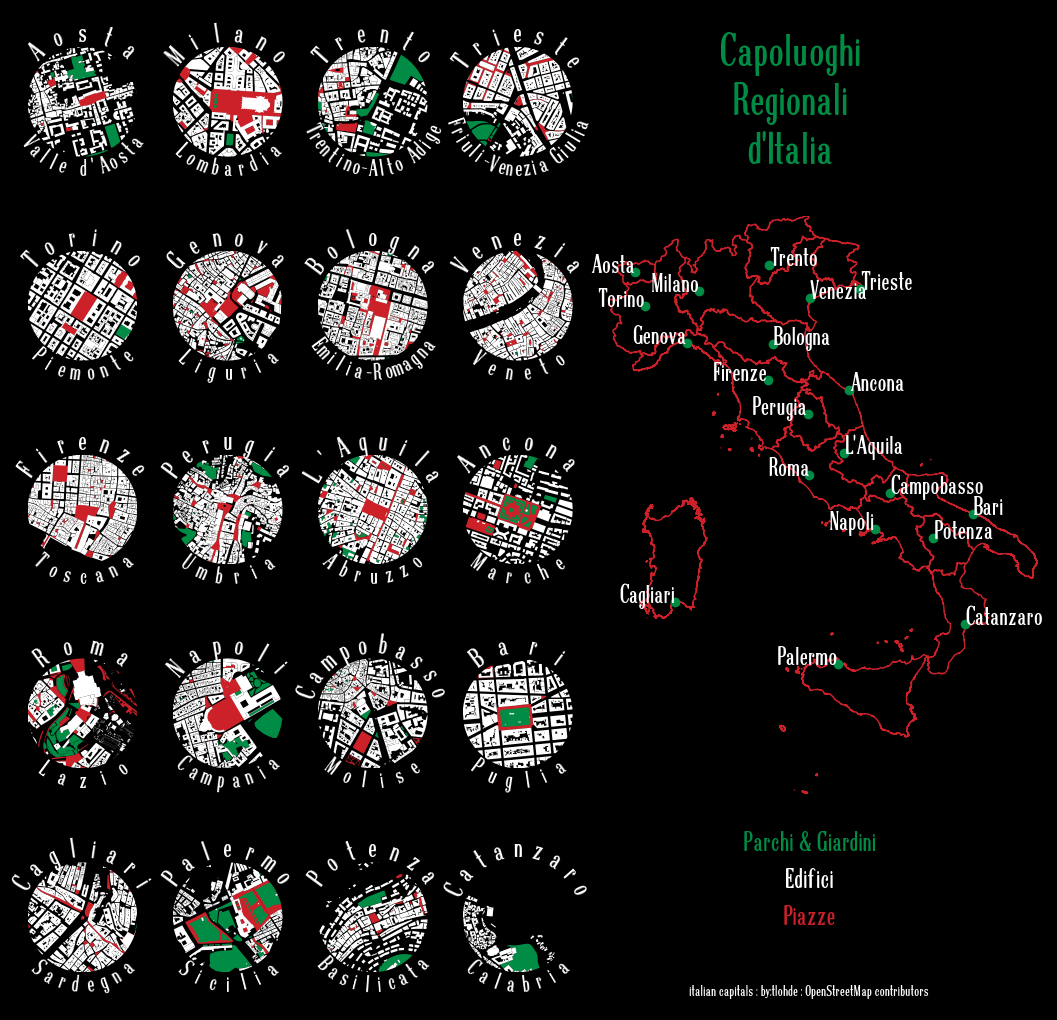

In [17]:
# do the plotting
fig, axs = plt.subplot_mosaic(grid,
                              width_ratios=[1, 1, 1, 1, 4],
                              gridspec_kw={'hspace': 0.1,
                                           'left': 0.2,
                                           'right': 0.8},
                              subplot_kw={'aspect': 'equal'},
                              figsize=[17, 13])

for row in gdf.itertuples():
    
    # iterate through each multipolygon column for each locality
    # colour changes per column
    for k, v in colordict.items():
        if getattr(row, k) is not None:
            (gdf.loc[gdf['name']==row.name]
             .set_geometry(k)
             .plot(ax=axs[row.name],
                   facecolor=v,
                   edgecolor='none'
                   )
             )
    
    # for setting axex limits
    minx, miny, maxx, maxy = row.buffer_utm.bounds
    
    # for getting coordinates along which to plot title
    x, y = row.buffer_utm.exterior.coords.xy

    # determine angular span of title
    span = norm(0.2,
                0.4,
                short_name,
                long_name,
                len(row.name))/2
    
    # get points along the curve centred on 
    # 0.75 way around circle perimieter 
    # which runs cw from 3 o'clock (so 0.75 is top centre)
    curve_points = (row.buffer_utm
                    .exterior
                    .interpolate(np.linspace(0.75-span, 0.75+span, 100),
                                 normalized=True)
    )
    curve = np.array([[p.x, p.y] for p in curve_points])
    text_along_path(row.name,
                    curve,
                    axs[row.name],
                    **{'ha':'center',
                       'va':'bottom',
                       'size':18,
                       'color':'w',
                       })
    
    # as above but for region name along bottom
    span = norm(0.2,
                0.4,
                short_region,
                long_region,
                len(row.region_name))/2
    curve_points = (row.buffer_utm
                    .buffer(10)
                    .exterior
                    .interpolate(np.linspace(0.25+span, 0.25-span, 100),
                                 normalized=True)
    )
    curve = np.array([[p.x, p.y] for p in curve_points])
    text_along_path(row.region_name,
                    curve,
                    axs[row.name],
                    **{'ha':'center',
                       'va':'top',
                       'size':15,
                       'color':'w',
                       })
    
    axs[row.name].set(xlim=(minx, maxx),
                      ylim=(miny, maxy))

## title and credits
axs['top'].annotate('Capoluoghi\nRegionali\nd\'Italia',
                    xy=(0.3, 0.5),
                    color=green,
                    xycoords='axes fraction',
                    fontsize=30,
                    ha='center',
                    va='center',
                    )

axs['bottom'].annotate('Parchi & Giardini',
                        xy=(0.4, 0.9),
                        color=green,
                        xycoords='axes fraction',
                        fontsize=18,
                        ha='center',
                        va='center',
                        )

axs['bottom'].annotate('Edifici',
                        xy=(0.4, 0.7),
                        color='w',
                        xycoords='axes fraction',
                        fontsize=18,
                        ha='center',
                        va='center',
                        )

axs['bottom'].annotate('Piazze',
                        xy=(0.4, 0.5),
                        color=red,
                        xycoords='axes fraction',
                        fontsize=18,
                        ha='center',
                        va='center',
                        )

axs['bottom'].annotate('italian capitals : by:tlohde : OpenStreetMap contributors',
                        xy=(0.4, 0.1),
                        color='w',
                        xycoords='axes fraction',
                        fontstyle='italic',
                        fontsize=10,
                        ha='center',
                        va='center',
                        )

# plot map of italy on rhs
# region outlines
(gdf.set_geometry('region')
 .to_crs(utm_crs)
 .plot(facecolor='none',
       edgecolor=red,
       ax=axs['right'])
)

# capital dots
gdf.plot(color=green,
         ax=axs['right'])

# annotations
for row in gdf.itertuples():
    if row.plot_col < 2:
        ha = 'right'
    else:
        ha = 'left'
    axs['right'].annotate(row.name,
                          xy=(row.x, row.y),
                          ha=ha,
                          size=17,
                          color='w')

minx, miny, maxx, maxy = italy.to_crs(utm_crs).total_bounds
axs['right'].set(xlim=(minx, maxx),
                 ylim=(miny, maxy))

for ax in axs.values():
    ax.set_axis_off()
    ax.set_facecolor('k')
    
fig.patch.set_color('k')


In [15]:
fig.savefig('day3.png', dpi=300, bbox_inches='tight')

## older messy method

In [3]:
# # using over pass because osmnx doesn't au
# overpass_url = "http://overpass-api.de/api/interpreter"

# # query for regional boundaries
# regions_query = """
# [out:json];
# area["name:en"~"Italy"][admin_level=2][boundary=administrative]->.aoi;
# nwr["admin_level"="4"]['ISO3166-2'~'IT'](area.aoi);
# out geom;
# """

# # run the query
# response = requests.get(overpass_url, 
#                         params={'data': regions_query})
# regions = response.json()

# # for each returned element, check if it has an `admin_centre`
# # member, if it does, add it admin_centres dict, and add it's
# # osmid to admin_centre refs
# regions_dict = {}
# admin_centre_refs = []
# for ele in regions['elements']:
#     for member in ele['members']:
#         if member['role'] == 'admin_centre':
#             regions_dict[ele['tags']['name']] = member
#             admin_centre_refs.append(member['ref'])
            
# # construct another overpass query for getting names of admin_centres            
# admin_centre_query = "".join([f'node({ref});' for ref in admin_centre_refs])
# admin_centre_query = f"[out:json];\n({admin_centre_query}); out tags;"

# response2 = requests.get(overpass_url, 
#                         params={'data': admin_centre_query})
# admin_centres = response2.json()

# # for each reurned element pair the osmid with the capital (admin_centre) name
# admin_centres_dict = {}
# for ele in admin_centres['elements']:
#     if 'name:it' in ele['tags'].keys():
#         admin_centres_dict[ele['id']] = ele['tags']['name:it']        
#     else:
#         admin_centres_dict[ele['id']] = ele['tags']['name']

# # add the admin_centre name to the regions
# for region, centre in regions_dict.items():
#     centre['name'] = admin_centres_dict[centre['ref']]


In [21]:
# # convert query results into geodataframe
# df = (pd.DataFrame(regions_dict)
#        .T
#        .reset_index()
#        .rename(columns={'index':'region'}))


# df['geometry'] = gpd.points_from_xy(df['lon'], df['lat'])
# gdf = gpd.GeoDataFrame(df, crs=4326)

# gdf = gdf.sort_values(by='lat', ascending=False)
# gdf['plot_row'] = np.repeat([0,1,2,3, 4], 4)
# gdf = gdf.sort_values(by=['plot_row', 'lon']).reset_index(drop=True)

# latloncrs = gdf.crs
# utm_crs = gdf.estimate_utm_crs()
# prj = ccrs.epsg(utm_crs.to_epsg())

# gdf = gdf.to_crs(utm_crs)
# gdf['buffer_utm'] = gdf.buffer(300)
# gdf['buffer_latlon'] = gdf['buffer_utm'].to_crs(latloncrs)

# tags = {
#     # 'natural': 'water',
#     'place': 'square',
#     'leisure': ['park', 'garden'],
#     'building':True,
#     }

# for key in tags.keys():
#     gdf[key] = pd.Series(dtype='geometry')

# for row in gdf.itertuples():

#     features = (ox.features_from_polygon(row.buffer_latlon,
#                                          tags=tags)
#                 .clip(row.buffer_latlon)
#                 .reset_index()
#                 .to_crs(utm_crs)
#                 )
    
#     features = features.loc[features.geom_type.isin(['Polygon', 'MultiPolygon'])]
    
#     # convert to multipolygon and add to gdf
#     for key in tags.keys():
#         if key in features.columns:
#             mp = MultiPolygon(
#                 features.loc[~features[key].isna(),'geometry']
#                 .explode(index_parts=False)
#                 .tolist()
#                 )
#             gdf.loc[row.Index, key] = mp